#### Importando bibliotecas

In [7]:
# Manipulação e visualização de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
# análise estatística
import statsmodels.tsa.api as smt 
from sklearn.linear_model import LinearRegression
from numpy import polyfit

In [8]:
import  warnings 
warnings.simplefilter('ignore')

In [9]:
# Configurando tamanho das imagens
rcParams['figure.figsize'] = 15, 6

#### Importando dados 

In [10]:
df = pd.read_excel('Data/vendas_varejo.xlsx')
df.head(2)

,Data,Indice
0,2000-01-01,53.2
1,2000-02-01,53.8


In [11]:
df.shape

(189, 2)

In [12]:
print(f'Valores faltantes: {df.isnull().values.any()}!')

Valores faltantes: False!


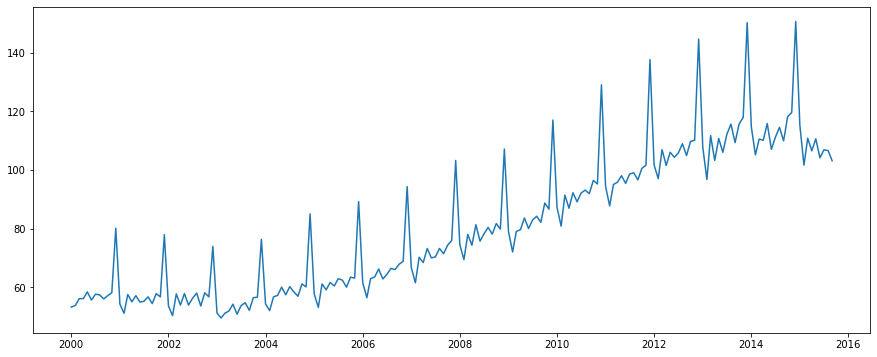

In [13]:
serie_vendas = pd.Series(df['Indice'].values, index=df['Data'])
plt.plot(serie_vendas)
plt.show()

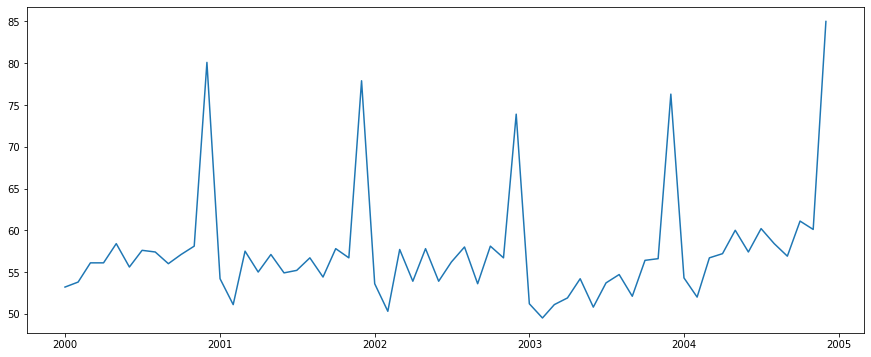

In [14]:
## Verificando o comportamento de 5 anos da série
plt.plot(serie_vendas[0:60])
plt.show()

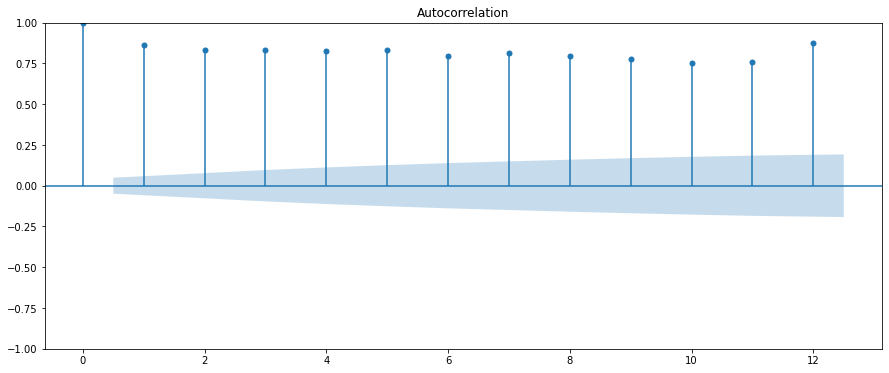

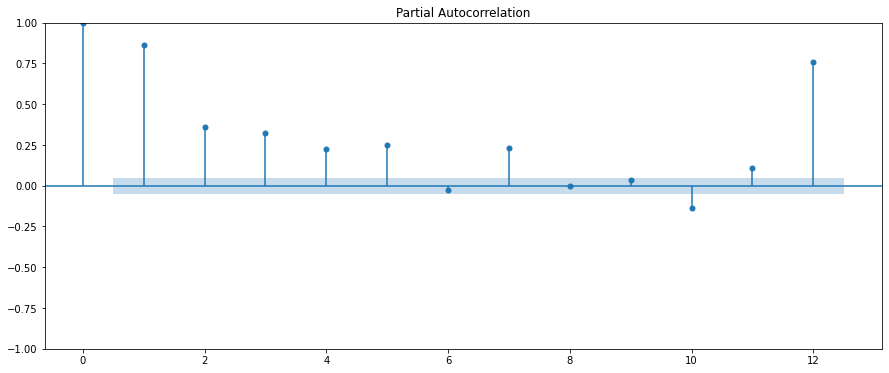

In [15]:
# Plotando FAC e FACP
smt.graphics.plot_acf(serie_vendas, lags=12, alpha=0.5);
smt.graphics.plot_pacf(serie_vendas, lags=12, alpha=0.5);

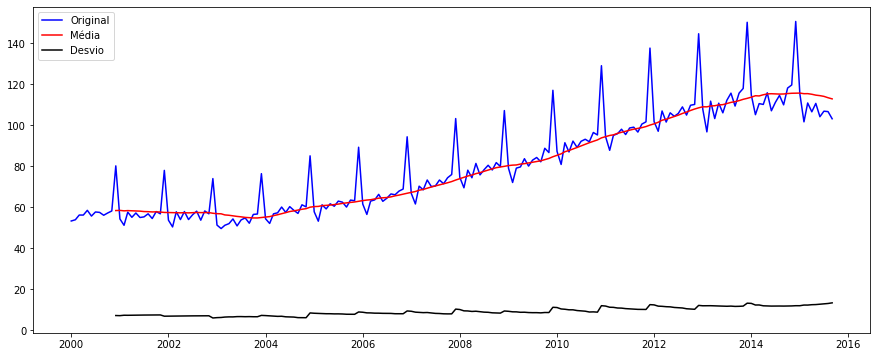

In [16]:
m_m = serie_vendas.rolling(window=12).mean()
m_std = serie_vendas.rolling(window=12).std() 

orig = plt.plot(serie_vendas, color='blue',label='Original')
mean = plt.plot(m_m, color='red',label='Média')
std = plt.plot(m_std, color='black',label='Desvio')
plt.legend(loc='best')
plt.show()

In [17]:
X = [i for i in range(0, len(serie_vendas))]
X = np.reshape(X, (len(X), 1))
y = serie_vendas
modelo = LinearRegression()
modelo.fit(X, y)  
modelo.coef_

array([0.38813559])

In [18]:
tendencia = modelo.predict(X)

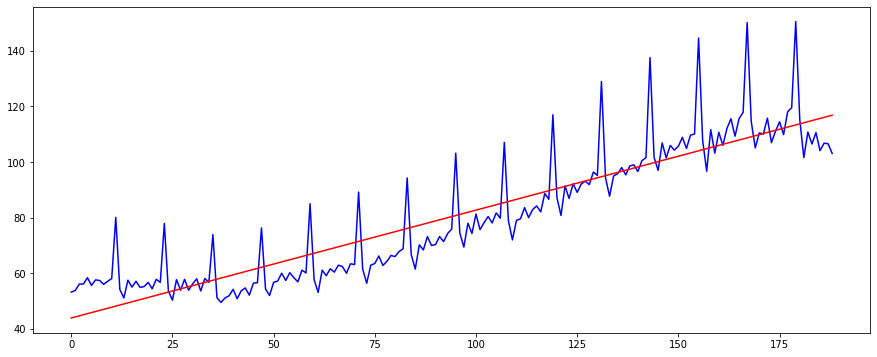

In [19]:
plt.plot(serie_vendas.values, color='blue',label='Original')
plt.plot(tendencia,color='red', label='Tendência' )
plt.show()

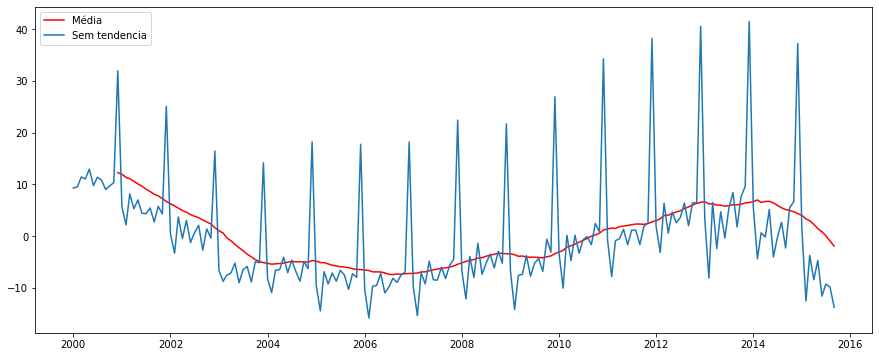

In [20]:
serie_sem_tendencia = serie_vendas - tendencia
m_m = serie_sem_tendencia.rolling(window=12).mean()
m_std = serie_sem_tendencia.rolling(window=12).std()
mean = plt.plot(m_m, color='red',label='Média')
# std = plt.plot(m_std, color='black',label='Desvio')
plt.plot(serie_sem_tendencia, label='Sem tendencia')
plt.legend(loc='best')
plt.show()

In [21]:
# ajuste polynomial: x^2*b1 + x*b2 + ... + bn
X = [i for i in range(0, len(serie_sem_tendencia))]
y = serie_sem_tendencia.values
degree = 12
coef = polyfit(X, y, degree)
print('Coefficients: %s' % coef)

Coefficients: [ 7.98009097e-22 -9.26556914e-19  4.69684472e-16 -1.36549241e-13
  2.51388949e-11 -3.05071867e-09  2.45767344e-07 -1.28432317e-05
  4.05520843e-04 -6.26527817e-03  5.66979752e-03  3.84941372e-01
  9.79964673e+00]


In [22]:
curva = []
for i in range(len(X)):
    valor = coef[-1]
    for d in range(degree):
        valor += X[i]**(degree-d) * coef[d]
    curva.append(valor)

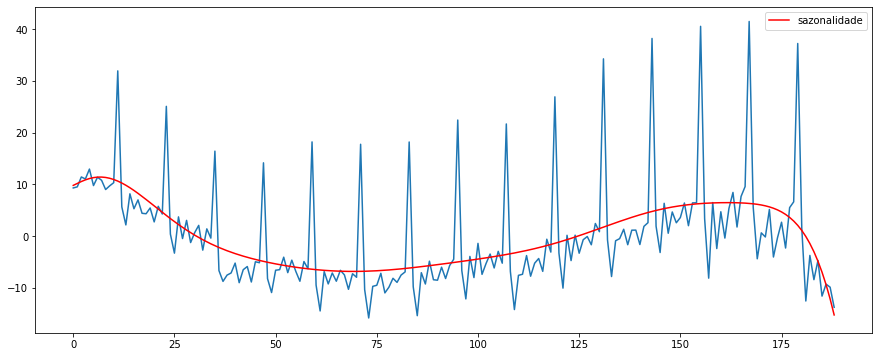

In [23]:
plt.plot(serie_sem_tendencia.values)
plt.plot(curva, color='red', label='sazonalidade')
plt.legend(loc='best')
plt.show()

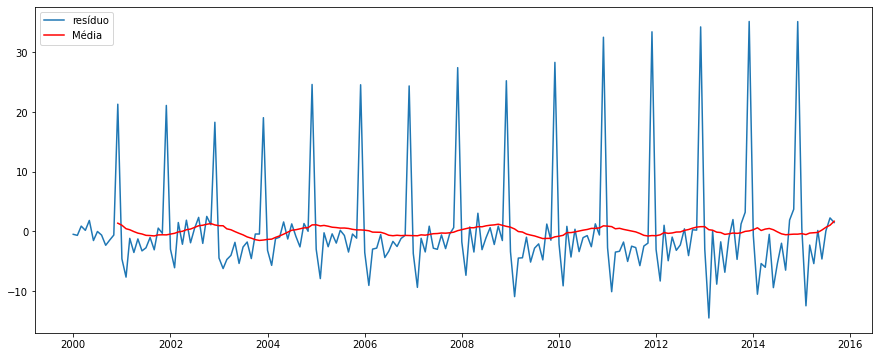

In [24]:
serie_sem_tendencia_sazonalidade = serie_sem_tendencia - curva
m_m = serie_sem_tendencia_sazonalidade.rolling(window=12).mean()
plt.plot(serie_sem_tendencia_sazonalidade, label='resíduo')
mean = plt.plot(m_m, color='red',label='Média')
plt.legend(loc='best')
plt.show()

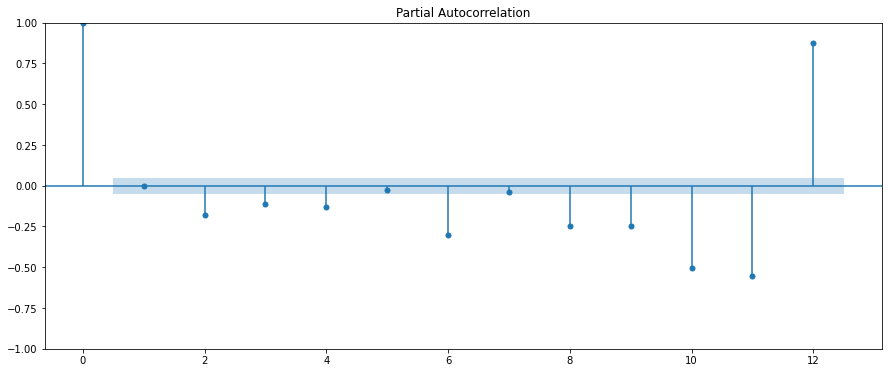

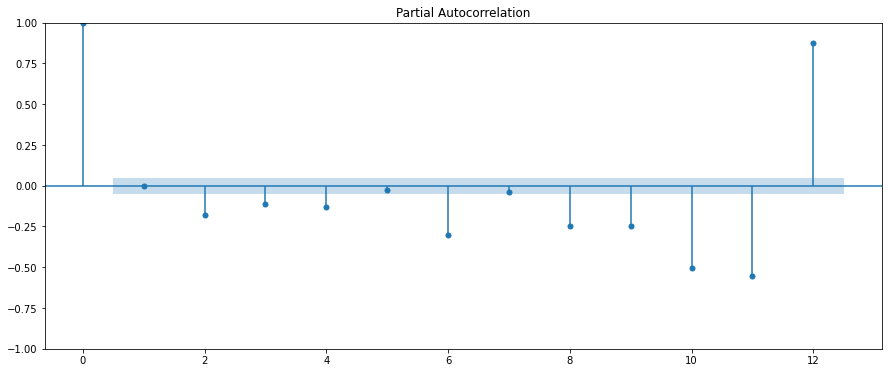

In [25]:
smt.graphics.plot_pacf(serie_sem_tendencia_sazonalidade, lags=12, alpha=0.5)

In [26]:
desvio = 2
random_normal = [i for i in np.random.normal(scale=desvio, size = len(serie_sem_tendencia_sazonalidade))]

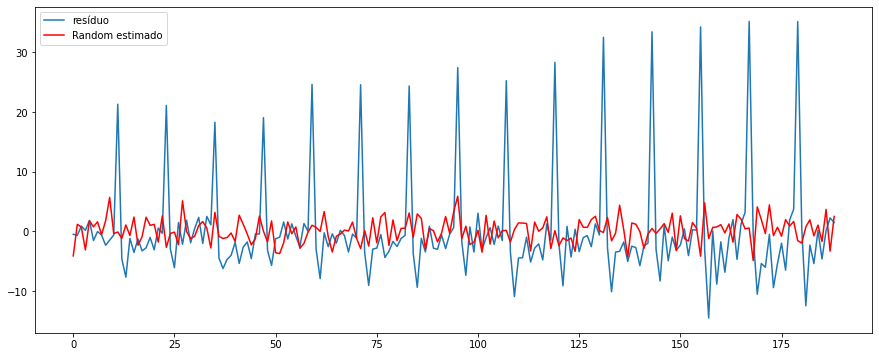

In [27]:
plt.plot(serie_sem_tendencia_sazonalidade.values, label='resíduo')
plt.plot(random_normal, color='red',label='Random estimado')
plt.legend(loc='best')
plt.show()

In [28]:
def previsao_tendencia(indices_anteriores, comp_tend):
    #prever a tendência utilizando uma reta estimada por regressão
    indices_anteriores = np.reshape(indices_anteriores, (len(indices_anteriores),1))
    
    prev_tendencia = comp_tend.predict(indices_anteriores)
    return prev_tendencia

In [29]:
def previsao_sazonalidade(indices_anteriores, comp_tend):
    #prever o valor do componente de sazonalidade utilizando ajuste polinomial 
    curva = []
    for i in range(len(indices_anteriores)):
        valor = comp_tend[-1]
        for d in range(degree):
            valor += indices_anteriores[i]**(degree-d) * comp_tend[d]
        curva.append(valor)
    return curva

In [30]:
def previsao_final(indices, comp_tend, comp_sazon, desv_random):
    #prever o valor da tendência
    tendencia = previsao_tendencia(indices, comp_tend)
    
    #prever o valor da sazonalidade
    sazonalidade = previsao_sazonalidade(indices, coef)
        
    #prever o valor do resíduo
    residuo = [i for i in np.random.normal(scale=desv_random, size = len(indices))]
    
    prev_final = tendencia + sazonalidade + residuo
    return prev_final 

In [31]:
# Prevendo os dados de treinamento
indices = [i for i in range(0, len(serie_vendas))]
prev_vendas= previsao_final(indices, modelo, coef, desvio)

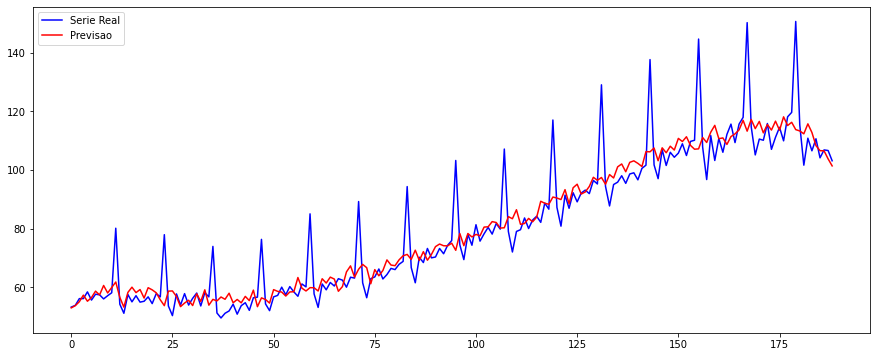

In [32]:
plt.plot(serie_vendas.values, color='blue', label='Serie Real')
plt.plot(prev_vendas, color='red', label='Previsao')
plt.legend(loc='best')
plt.show()


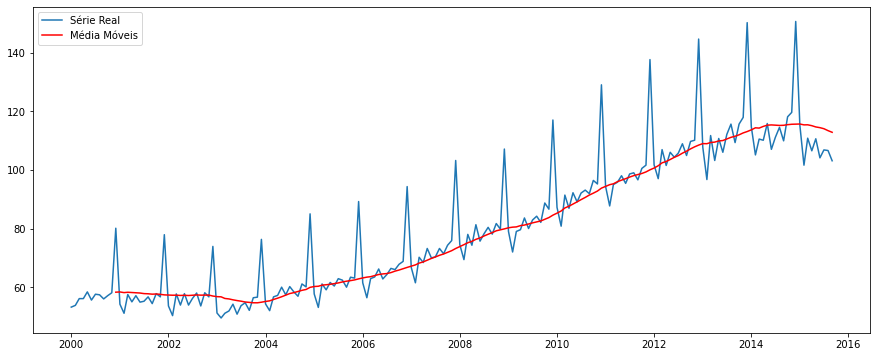

In [33]:
rolling = serie_vendas.rolling(window=12)
media_mov = rolling.mean()
# plot original and transformed dataset
plt.plot(serie_vendas, label='Série Real')
plt.plot(media_mov,color='red', label='Média Móveis')
plt.legend(loc='best')
plt.show()

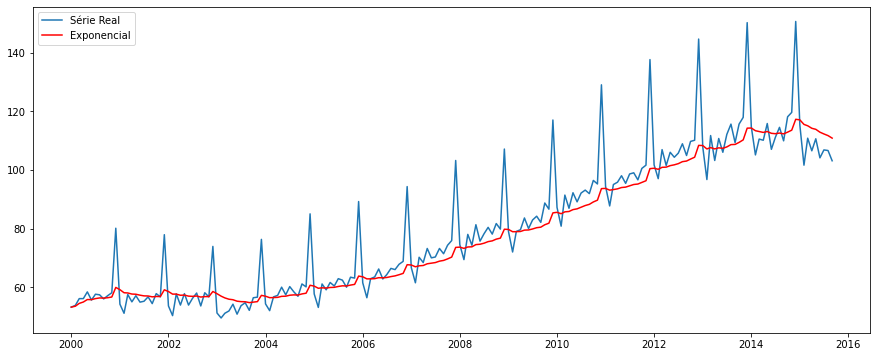

In [34]:
rolling =  serie_vendas.ewm(alpha =0.1)
suav_exp = rolling.mean()
plt.plot(serie_vendas, label='Série Real')
plt.plot(suav_exp,color='red', label='Exponencial')
plt.legend(loc='best')
plt.show()

<AxesSubplot:xlabel='Data'>

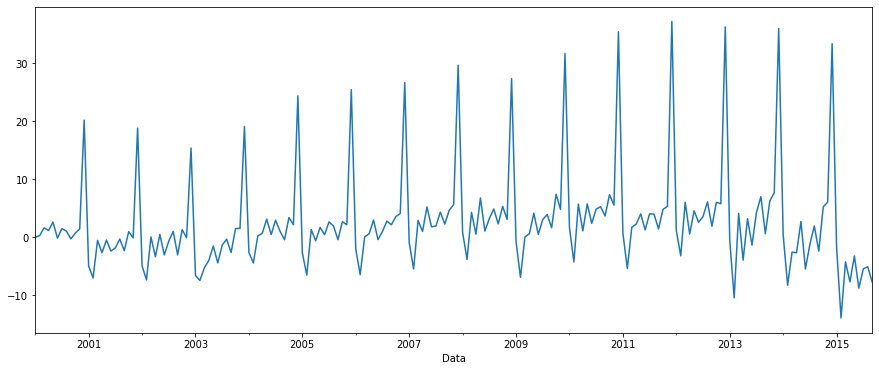

In [35]:
serie_sem_tendencia = serie_vendas - suav_exp  # Série - componente de tendência
serie_sem_tendencia.plot()

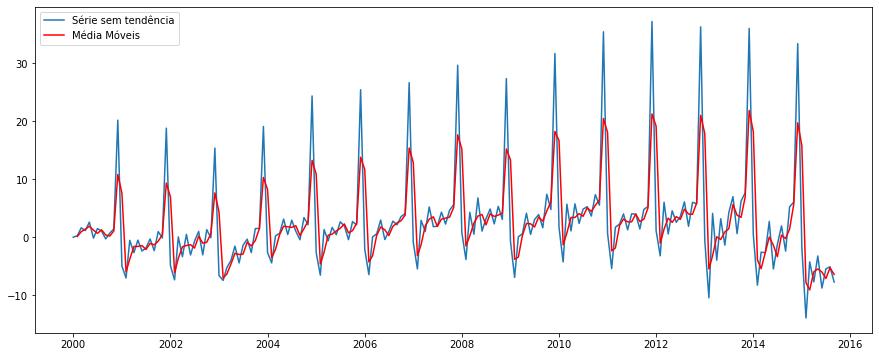

In [36]:
#Aplica média móveis na série sem a tendência 
rolling = serie_sem_tendencia.rolling(window=2)
saz_mean_mov = rolling.mean()
# plot original and transformed dataset
plt.plot(serie_sem_tendencia, label='Série sem tendência')
plt.plot(saz_mean_mov,color='red', label='Média Móveis')
plt.legend(loc='best')
plt.show()

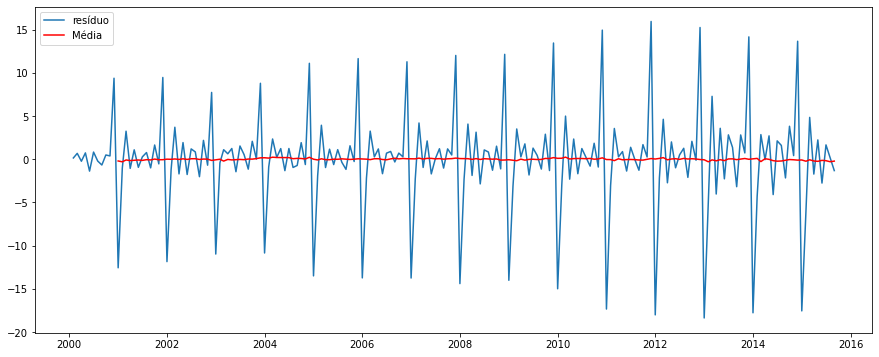

In [37]:
serie_residuo = serie_sem_tendencia - saz_mean_mov #Elimina o componente de sazonalidade 
m_m = serie_residuo.rolling(window=12).mean()
plt.plot(serie_residuo, label='resíduo')
mean = plt.plot(m_m, color='red',label='Média')
plt.legend(loc='best')
plt.show()

In [38]:
desvio = 2
random_normal = [i for i in np.random.normal(scale=desvio, size = len(serie_residuo))]

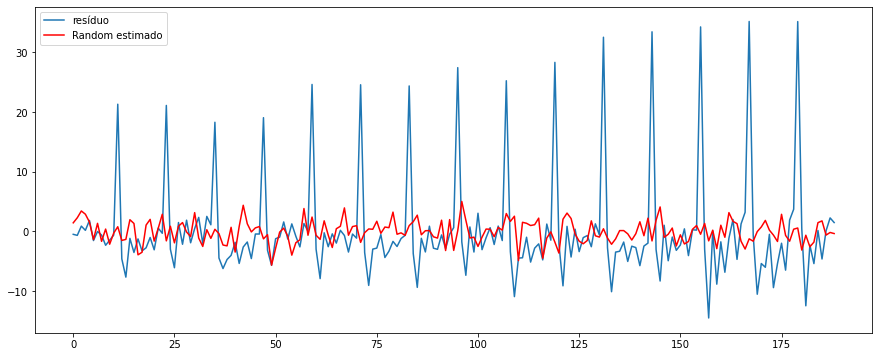

In [39]:
plt.plot(serie_sem_tendencia_sazonalidade.values, label='resíduo')
plt.plot(random_normal, color='red',label='Random estimado')
plt.legend(loc='best')
plt.show()

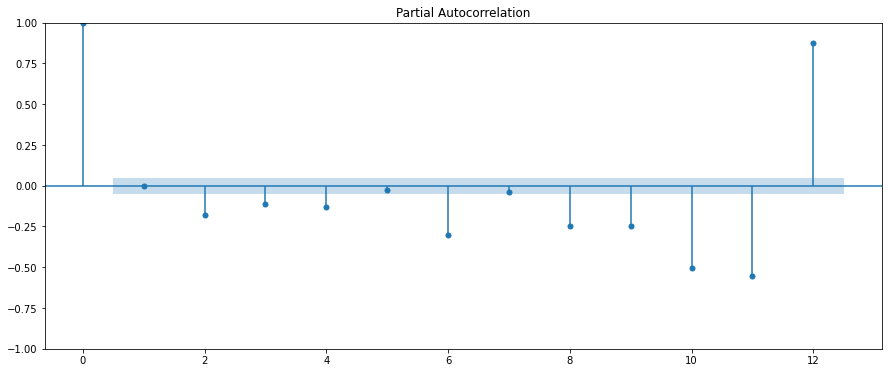

In [41]:
# plot_acf(dados_ruido.dropna());
# dados_ruido.dropna(inplace=True) # retira os NaN
smt.graphics.plot_pacf(serie_sem_tendencia_sazonalidade.values, lags=12, alpha=0.5)
plt.show()